# Preamble

In [1]:
# %%sh
# sudo apt install fonts-cmu texlive-latex-extra cm-super dvipng
# mkdir out

In [48]:
import copy
from typing import *

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import wandb
import wandb.apis

sns.set_context("paper", font_scale=1.5)
matplotlib.rc('font', **{'family': 'serif', 'serif': ["CMU Serif"]})
matplotlib.rc('text', usetex=True)
matplotlib.font_manager.findfont("CMU Serif", rebuild_if_missing=True)

api = wandb.Api()

In [49]:
def load_one(run: wandb.apis.public.Run) -> Dict[str, Any]:
    if "count" in run.summary:
        task = run.config["task"]["name"]
        mc = run.summary["model_config"]
        score_key = dict(
            squad="match",
            squad_train="match",
            triviaqa="match",
            cnn_dailymail="rougeL",
            wikitext_bpc="bpc",
            repetition="match_length_char",
        )[task]
        sparsity = copy.deepcopy(run.config["sparsity"])
        assert sparsity.pop("score", None) in [None, "sparse_q"]
        scores = [r[score_key] for r in run.summary["results"]]
        return dict(
            task=task,
            confusion_contexts=run.config["task"].get("confusion_contexts"),
            model=run.config["model"].split("/")[1].replace("-hf", "").lower(),
            n_heads=mc["num_attention_heads"] * mc["num_hidden_layers"],
            head_size=mc["hidden_size"]//mc["num_attention_heads"],
            **sparsity,
            prefill_length=run.summary["prefill_length"],
            score=np.mean(scores),
            score_stderr=np.sqrt(np.var(scores) / len(scores)),
        )

def load_sweep(experiment_name: str, *single_runs: str) -> pd.DataFrame:
    return pd.DataFrame.from_dict(filter(None, (
        load_one(run)
        for run in api.runs(
            "research/sparse-attention", {"$or": [
                {"config.name": experiment_name},
                *({"display_name": n} for n in single_runs)
            ]}
        )
    )))

def memory_transfers_attention_only(s: pd.Series, count_kv: bool = True, count_index: bool = True) -> int:
    kv_elements, index_elements = 0, 0  # per-head
    if s["name"] == "dense":
        # write 1*(k, v) + read all prefill_length*(k, v)
        kv_elements = (2 + 2 * s["prefill_length"]) * s["head_size"]

    elif s["name"] == "sparse_v":
        # write 1*(k, v) + read all prefill_length*k + read sparse_k*v
        kv_elements = (2 + s["prefill_length"] + s["k"]) * s["head_size"]

    elif s["name"] == "local":
        # write 1*(k, v) + read sparse_k*v
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]

    elif s["name"] == "eviction":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write scores
        index_elements = (1 + 2 * s["prefill_length"])

    elif s["name"] == "ann":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write index
        index_elements = s["head_size"] + s["prefill_length"] * s["rank"]
        if s["reallocate_to_mean_value"]:
            index_elements += 2 * s["head_size"]

    else:
        assert False, s["name"]

    return (count_kv * kv_elements + count_index * index_elements) * s["n_heads"]

# Benchmarking

In [63]:
ipu_kernel_names = {
    "attn-local": "Dense (local SRAM)",
    "attn-remote": "Dense",
    "sparq-attn": "SparQ",
}
gpu_kernel_names = {
    "attn-torch": "Dense",
    "attn-mem-efficient": "Dense (ME)",
    "sparq-attn-triton-oneK": "SparQ ($K$ once)",
    "sparq-attn-compiled": "SparQ (plain)",
    "sparq-attn-triton": "SparQ",
}
def theoretical_bytes(s: pd.Series) -> int:
    dsize = dict(float16=2, float32=4)[s["dtype"]]
    if "sparq" in s.kernel:
        return dsize * s.n_head * (s.k1 * s.sequence_length + 2 * s.k2 * s.head_dim)
    return dsize * s.n_head * (2 * s.sequence_length * s.head_dim)

df = (pd.read_json("benchmarks.json")
    .pipe(lambda d: d.assign(
        duration=d.duration/d.batch_size,  # convert duration to per-query
        stderr_ratio=d.duration_stderr/d.duration,
        theoretical_bytes=d.apply(theoretical_bytes, axis=1),
        baseline=d.kernel.apply(lambda x: not ("sparq" in x or x == "attn-local")),
        device=d.device.apply(dict(ipu="ipu", cuda="gpu", cpu="cpu").__getitem__),
        device_name=d.device_name.apply(lambda n: {
            "M2000": "M2000",
            "NVIDIA A10G": "A10G",
            "NVIDIA A100-SXM4-40GB": "A100-40GB"
        }.get(n, n))
    ))
    .pipe(lambda d: d.assign(achieved_bandwidth=d.theoretical_bytes/d.duration))
    .groupby(["device_name", "sequence_length", "batch_size"])
        .apply(lambda d: d.assign(  # Speedup per batch size (not for best batch size)
            speedup=d[d.baseline].duration.min() / d.duration,
            theoretical_speedup=d[d.baseline].theoretical_bytes.min() / d.theoretical_bytes,
        ))
        .reset_index(drop=True)
    [["device", "device_name", "sequence_length", "batch_size",
      "kernel", "k1", "k2", "baseline", "theoretical_bytes", "theoretical_speedup",
      "duration", "stderr_ratio", "speedup", "achieved_bandwidth"]]
)

In [56]:
k1, k2 = 32, 128
sequence_length = 4096

batch_size = 64
print(f"GPU sequence_length={sequence_length}, batch_size={batch_size}, k1={k1}, k2={k2}")

display(df
    .pipe(lambda d: d[d.device == "gpu"])
    .pipe(lambda d: d[d.kernel.isin(["attn-torch", "attn-mem-efficient"]) | ((d.k1==k1) & (d.k2==k2))])
    .pipe(lambda d: d[~d.kernel.isin(["sparq-attn-torch-oneK", "sparq-attn-compiled-oneK", "sparq-attn-torch"])])
    .pipe(lambda d: d[d.batch_size == batch_size])
    .pipe(lambda d: d[d.sequence_length == sequence_length])
    .pipe(lambda d: d.assign(
        kernel=d.kernel.apply(gpu_kernel_names.__getitem__),
        result=d.apply(lambda x: f"{x.duration*1e6:.0f} us ({x.speedup:.2f})", axis=1),
        stderr_ratio=d.apply(lambda x: f"{x.stderr_ratio*100:.2f} %", axis=1),
    ))
    .pivot_table(index=["kernel"], columns="device_name", values=["result", "speedup", "theoretical_speedup", "stderr_ratio"], aggfunc="first")
    .swaplevel(axis=1)
    .sort_values(("A100-40GB", "speedup"))
    .drop(columns=[("A100-40GB", "speedup"), ("A10G", "speedup")])
)

sequence_length = 16384
batch_size = 1
print(f"IPU sequence_length={sequence_length}, batch_size={batch_size}, k1={k1}, k2={k2}")

display(df
    .pipe(lambda d: d[d.device == "ipu"])
    .pipe(lambda d: d[d.kernel.isin(["attn-remote", "attn-local"]) | ((d.k1==k1) & (d.k2==k2))])
    .pipe(lambda d: d[d.batch_size == batch_size])
    .pipe(lambda d: d[d.sequence_length == sequence_length])
    .pipe(lambda d: d.assign(
        kernel=d.kernel.apply(ipu_kernel_names.__getitem__),
        result=d.apply(lambda x: f"{x.duration*1e6:.0f} us ({x.speedup:.2f})", axis=1),
        stderr_ratio=d.apply(lambda x: f"{x.stderr_ratio*100:.2f} %", axis=1),
    ))
    .pivot_table(index=["kernel"], values=["result", "speedup", "theoretical_speedup", "stderr_ratio"], aggfunc="first")
    .sort_values("speedup")
    .drop(columns="speedup")
)

GPU sequence_length=4096, batch_size=64, k1=32, k2=128


device_name,A100-40GB,A10G,A100-40GB,A10G,A100-40GB,A10G
,result,result,stderr_ratio,stderr_ratio,theoretical_speedup,theoretical_speedup
kernel,,,,,,
Dense (ME),50 us (0.98),128 us (1.00),0.02 %,0.00 %,1.0,1.0
Dense,49 us (1.00),135 us (0.95),0.03 %,0.04 %,1.0,1.0
SparQ ($K$ once),38 us (1.28),79 us (1.63),0.27 %,0.04 %,6.4,6.4
SparQ (plain),37 us (1.33),78 us (1.65),0.73 %,0.02 %,6.4,6.4
SparQ,16 us (3.02),31 us (4.17),0.29 %,0.02 %,6.4,6.4


IPU sequence_length=16384, batch_size=1, k1=32, k2=128


,result,stderr_ratio,theoretical_speedup
kernel,,,
Dense,40432 us (1.00),0.00 %,1.000000
SparQ,5457 us (7.41),0.00 %,7.529412
Dense (local SRAM),134 us (302.34),0.00 %,1.000000


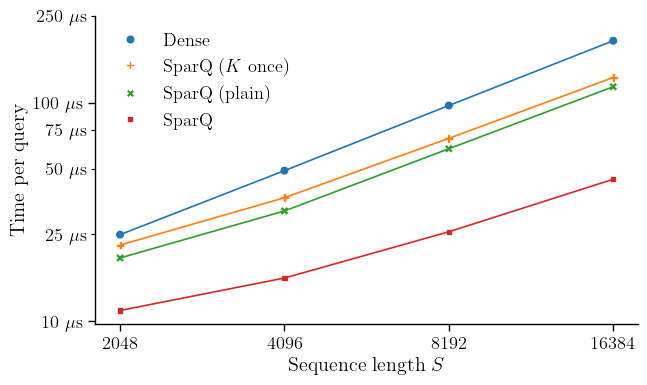

In [57]:
d = (df
    .pipe(lambda d: d[d.device_name == "A100-40GB"])
    .pipe(lambda d: d[d.kernel.isin(["attn-torch", "sparq-attn-compiled", "sparq-attn-triton-oneK", "sparq-attn-triton"])])
    .pipe(lambda d: d[d.kernel.isin(["attn-torch"]) | ((d.k1==32) & (d.k2==64))])
    .pipe(lambda d: d[d.batch_size == 64])
    .pipe(lambda d: d[d.sequence_length <= 16384])
    .pipe(lambda d: d.assign(kernel=d.kernel.apply(gpu_kernel_names.__getitem__)))
)

plt.figure(figsize=(7, 4))
hue_order = [k for k in gpu_kernel_names.values() if k in set(d.kernel)]
ax = sns.scatterplot(data=d, y="duration", x="sequence_length", hue="kernel", hue_order=hue_order, style="kernel", s=40)
sns.lineplot(data=d, y="duration", x="sequence_length", hue="kernel", hue_order=hue_order, legend=False)
ax.set_xscale("log", base=2)
ax.xaxis.set_major_formatter("{x:.0f}")
ax.set_yscale("log")
ax.legend(frameon=False)
ax.yaxis.set_major_formatter(lambda x, _: f"{x*1e6:.0f} $\mu$s")
ax.yaxis.set_minor_formatter(lambda x, _: f"{x*1e6:.0f} $\mu$s")
ax.set_xlabel("Sequence length $S$")
ax.set_ylabel("Time per query")
ax.set_yticks([25e-6, 50e-6, 75e-6, 250e-6], minor=True)
sns.despine(ax=ax)
plt.savefig(f"out/benchmark_a100_b64.pdf", bbox_inches="tight")

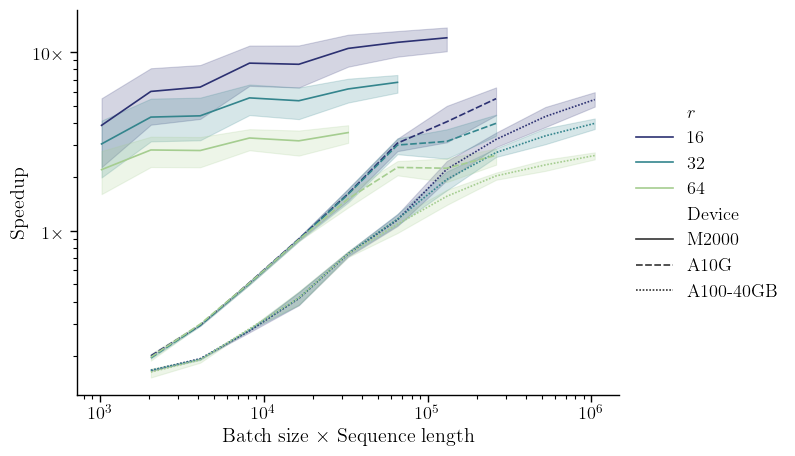

In [64]:
plt.figure(figsize=(7, 5))
ax = sns.lineplot(data=df
 .pipe(lambda d: d[d.kernel.isin(["sparq-attn", "sparq-attn-triton"])])
 .pipe(lambda d: d.assign(k1=d.k1.apply(int), k2=d.k2.apply(int), nelement=d.batch_size * d.sequence_length)),
    x="nelement", y="speedup", hue="k1", hue_norm=matplotlib.colors.LogNorm(),
    style="device_name", style_order=["M2000", "A10G", "A100-40GB"],
    palette="crest_r",
)
sns.despine(ax=ax)
ax.set_ylabel("Speedup")
ax.set_xlabel(r"Batch size $\times$ Sequence length")
ax.set_yscale("log")
ax.set_xscale("log")
ax.yaxis.set_major_formatter("${x:.0f}\\times$")
handles, labels = ax.get_legend_handles_labels()
labels[labels.index("k1")] = "$r$"
labels[labels.index("device_name")] = "Device"
ax.legend(handles, labels, loc="center left", bbox_to_anchor=(1.0, 0.5), frameon=False)
plt.savefig(f"out/benchmark_scaling.pdf", bbox_inches="tight");

# Scaling sequence length

In [58]:
df = (pd.concat([load_sweep("RMOE-78-long-context-v3")]).reset_index(drop=True)
    .pipe(lambda d: d.assign(transfers=d.apply(memory_transfers_attention_only, axis=1)))
    [["model", "confusion_contexts", "name", "k", "rank", "transfers", "prefill_length", "score", "score_stderr"]]
)

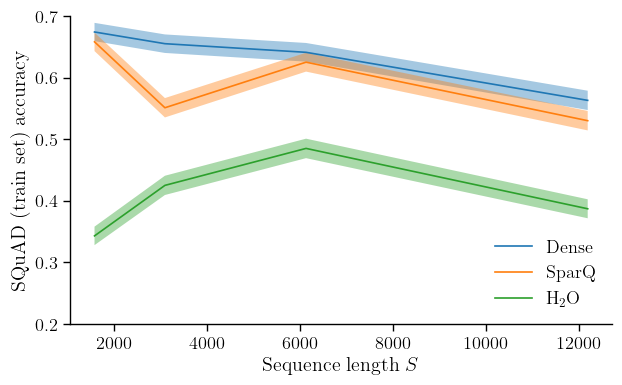

In [61]:
techniques = dict(
    dense="Dense",
    ann="SparQ",
    eviction="H$_2$O",
)
plt.figure(figsize=(7, 4))
ax = plt.gca()
for name, label in techniques.items():
    g = df[(df["name"] == name) & (df["confusion_contexts"] >= 7)].sort_values("prefill_length")
    ax.plot(g.prefill_length, g.score, label=label)
    ax.fill_between(g.prefill_length, g.score - g.score_stderr, g.score + g.score_stderr,
                    alpha=.4)
ax.legend(frameon=False)
ax.set_xlabel("Sequence length $S$")
ax.set_ylabel("SQuAD (train set) accuracy")
ax.set_ylim((0.2, 0.7))
sns.despine(ax=ax)
plt.savefig(f"out/sequence_length_scaling.pdf", bbox_inches="tight")